In [1]:
import os
import time
import torch 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from datasets.load_dataset import GardensPointDataset, SFUDataset
from matching import matching
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt

c:\Users\Irfan Q\miniconda3\envs\bruh\Lib\site-packages\onnxruntime\capi\onnxruntime_validation.py:26: UserWarning: Unsupported Windows version (11). ONNX Runtime supports Windows 10 and above, only.
  warnings.warn(


# Constants

In [2]:
WEIGHTS_FILE = "calc.caffemodel.pt"

SFU_QUERY = 'images\SFU\jan'
SFU_MAP = 'images\SFU\dry'

# GARDEN_QUERY = 'images\GardensPoint\day_left'
# GARDEN_MAP = 'images\GardensPoint\day_right'
# GARDEN_MAP2 = 'images\GardensPoint\night_right'

<>:3: SyntaxWarning: invalid escape sequence '\S'
<>:4: SyntaxWarning: invalid escape sequence '\S'
<>:3: SyntaxWarning: invalid escape sequence '\S'
<>:4: SyntaxWarning: invalid escape sequence '\S'
C:\Users\Irfan Q\AppData\Local\Temp\ipykernel_32952\4210290530.py:3: SyntaxWarning: invalid escape sequence '\S'
  SFU_QUERY = 'images\SFU\jan'
C:\Users\Irfan Q\AppData\Local\Temp\ipykernel_32952\4210290530.py:4: SyntaxWarning: invalid escape sequence '\S'
  SFU_MAP = 'images\SFU\dry'


## Pre-process

In [3]:
class ConvertToYUVandEqualizeHist:
    def __call__(self, img):
        img_yuv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2YUV)
        img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
        img_rgb = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
        return Image.fromarray(img_rgb)

preprocess = transforms.Compose(
    [
        ConvertToYUVandEqualizeHist(),
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((120, 160), interpolation=Image.BICUBIC),
        transforms.ToTensor(),
    ]
)

## Model Definition

In [4]:
class CalcModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.input_dim = (1, 120, 160)
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(5, 5), stride=2, padding=4)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(4, 4), stride=1, padding=2)
        self.conv3 = nn.Conv2d(128, 4, kernel_size=(3, 3), stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=(3, 3), stride=2)
        self.lrn1 = nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75)
        self.lrn2 = nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.lrn1(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.lrn2(x)

        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        return x
    
# Onnx
# PCA, TSNE

In [5]:
# Instantiate the Model
calc = CalcModel()

# Load the model weights
state_dict = torch.load(WEIGHTS_FILE)
my_new_state_dict = {}
my_layers = list(calc.state_dict().keys())
for layer in my_layers:
    my_new_state_dict[layer] = state_dict[layer]
calc.load_state_dict(my_new_state_dict)

SFUDataset().load()

===== Load dataset SFU dry--jan


([array([[[ 20,  27,  20],
          [ 22,  27,  21],
          [ 24,  29,  25],
          ...,
          [ 16,  14,  15],
          [ 16,  14,  15],
          [ 16,  14,  15]],
  
         [[ 19,  26,  19],
          [ 21,  26,  20],
          [ 23,  28,  24],
          ...,
          [ 16,  14,  15],
          [ 16,  14,  15],
          [ 16,  14,  15]],
  
         [[ 19,  24,  18],
          [ 20,  25,  21],
          [ 23,  25,  22],
          ...,
          [ 16,  14,  15],
          [ 16,  14,  15],
          [ 16,  14,  15]],
  
         ...,
  
         [[106,  96,  94],
          [108,  98,  96],
          [111, 101,  99],
          ...,
          [ 16,  15,  20],
          [ 16,  15,  20],
          [ 16,  15,  20]],
  
         [[101,  90,  88],
          [104,  93,  91],
          [108,  97,  95],
          ...,
          [ 16,  15,  20],
          [ 16,  15,  20],
          [ 16,  15,  20]],
  
         [[ 99,  85,  82],
          [103,  89,  86],
          [106,  95,  91

In [6]:
# Preprocess query images

query_matrix = []

for image in os.listdir(SFU_QUERY):
    image_path = os.path.join(SFU_QUERY, image)
    image = Image.open(image_path)
    preprocessed_image = preprocess(image)
    query_matrix.append(preprocessed_image)

query_matrix = np.stack(query_matrix, axis=0)

# Convert numpy array to a tensor
query_tensor = torch.from_numpy(query_matrix)

print(query_tensor.shape)
print(query_tensor)

torch.Size([385, 1, 120, 160])
tensor([[[[0.5725, 0.6667, 0.6784,  ..., 0.3098, 0.1569, 0.0941],
          [0.2157, 0.5686, 0.7490,  ..., 0.2588, 0.1569, 0.0941],
          [0.0667, 0.1804, 0.6667,  ..., 0.2235, 0.1569, 0.1059],
          ...,
          [0.2980, 0.3529, 0.4314,  ..., 0.8196, 0.7961, 0.7725],
          [0.1725, 0.2863, 0.4196,  ..., 0.8196, 0.7882, 0.7490],
          [0.1725, 0.2745, 0.3765,  ..., 0.8118, 0.7569, 0.6824]]],


        [[[0.8627, 0.9451, 0.9373,  ..., 0.9647, 0.8980, 0.8275],
          [0.8980, 0.9059, 0.9451,  ..., 0.9804, 0.9333, 0.8824],
          [0.4314, 0.6039, 0.9176,  ..., 0.9804, 0.9529, 0.9137],
          ...,
          [0.3137, 0.3922, 0.4784,  ..., 0.5451, 0.5961, 0.6118],
          [0.2667, 0.3294, 0.3804,  ..., 0.5137, 0.5255, 0.5529],
          [0.1922, 0.2588, 0.3098,  ..., 0.5020, 0.4941, 0.5059]]],


        [[[0.0039, 0.0000, 0.0039,  ..., 0.9765, 0.9373, 0.7765],
          [0.0039, 0.0039, 0.0078,  ..., 0.9686, 0.9569, 0.8667],
       

In [7]:
# Preprocess map images

map_matrix = []

for image in os.listdir(SFU_MAP):
    image_path = os.path.join(SFU_MAP, image)
    image = Image.open(image_path)
    preprocessed_image = preprocess(image)
    map_matrix.append(preprocessed_image)

map_matrix = np.stack(map_matrix, axis=0)

# Convert numpy array to a tensor
map_tensor = torch.from_numpy(map_matrix)

print(map_tensor.shape)
print(map_tensor)

torch.Size([385, 1, 120, 160])
tensor([[[[0.3098, 0.4431, 0.6235,  ..., 0.0314, 0.0196, 0.0196],
          [0.1882, 0.4471, 0.7020,  ..., 0.0471, 0.0353, 0.0353],
          [0.1412, 0.4392, 0.6510,  ..., 0.0431, 0.0314, 0.0353],
          ...,
          [0.7882, 0.8157, 0.8314,  ..., 0.1529, 0.1176, 0.0824],
          [0.7961, 0.8118, 0.8353,  ..., 0.1333, 0.0902, 0.0627],
          [0.7843, 0.8000, 0.8196,  ..., 0.0980, 0.0588, 0.0431]]],


        [[[0.6275, 0.6039, 0.5804,  ..., 0.8118, 0.8000, 0.7569],
          [0.5216, 0.5333, 0.5176,  ..., 0.8157, 0.7922, 0.7333],
          [0.3922, 0.4863, 0.4706,  ..., 0.8078, 0.7765, 0.7294],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 0.2667, 0.1843, 0.1373],
          [1.0000, 1.0000, 1.0000,  ..., 0.2392, 0.1373, 0.1098],
          [1.0000, 1.0000, 1.0000,  ..., 0.1490, 0.0980, 0.0588]]],


        [[[0.0902, 0.2039, 0.3294,  ..., 0.8392, 0.8980, 0.9451],
          [0.1529, 0.2510, 0.3490,  ..., 0.8627, 0.8706, 0.9412],
       

In [8]:
query_tensor = torch.from_numpy(query_matrix)
map_tensor = torch.from_numpy(map_matrix)

query_tensor = query_tensor.view(-1, 1, 120, 160)
map_tensor = map_tensor.view(-1, 1, 120, 160)

# Pass the tensors through the model

query_features = calc(query_tensor)
map_features = calc(map_tensor)

print(query_features.shape)
print(map_features.shape)

torch.Size([385, 936])
torch.Size([385, 936])


In [9]:
iterations = 100

In [10]:
start_time = time.time()

for _ in range(iterations):
    output = calc(query_tensor)

end_time = time.time()

query_duration = end_time - start_time
query_avg_duration = query_duration / iterations

print(f"Time taken: {query_duration} seconds")
print(f"Average time taken: {query_avg_duration} seconds")

Time taken: 57.64820837974548 seconds
Average time taken: 0.5764820837974548 seconds


In [11]:
start_time = time.time()

for _ in range(iterations):
    output = calc(map_tensor)

end_time = time.time()

map_duration = end_time - start_time
map_avg_duration = map_duration / iterations

print(f"Time taken: {map_duration} seconds")
print(f"Average time taken: {map_avg_duration} seconds")

Time taken: 50.02480912208557 seconds
Average time taken: 0.5002480912208557 seconds


# Evaluation

In [12]:
from sklearn.metrics.pairwise import cosine_similarity

# Convert pytorch tensors to numpy arrays
query_features_np = query_features.detach().numpy()
map_features_np = map_features.detach().numpy()

similarity_matrix = cosine_similarity(query_features_np, map_features_np)

print(similarity_matrix.shape)

(385, 385)


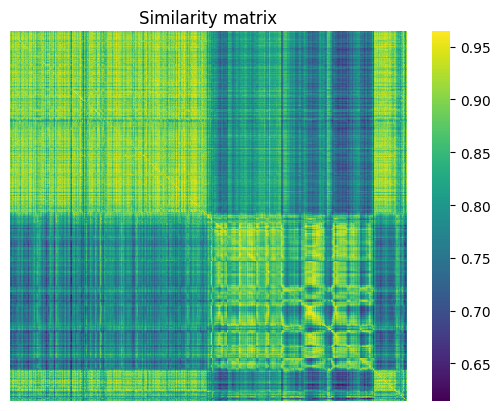

In [13]:
plt.figure()
sns.heatmap(similarity_matrix, cmap='viridis')
plt.title('Similarity matrix')
plt.axis('off')
plt.show()

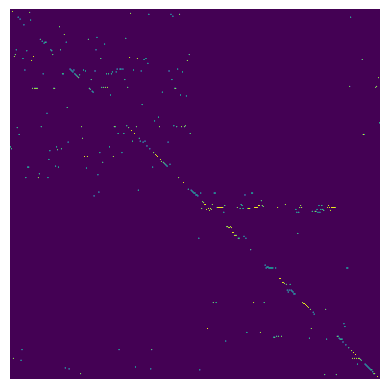

In [14]:
M1 = matching.best_match_per_query(similarity_matrix)

fig = plt.figure()

ax1 = fig.add_subplot(111)
ax1.imshow(M1)
ax1.axis('off')

plt.show()